# Custom Gibbs Sampler

In this notebook I present the usage and fit results of the custom Gibbs sampler. 

---

## Setup

In [25]:
## Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
tf.random.set_seed(42)

In [26]:
## from ../src
from importlib import reload  
import sys
if "../" not in sys.path: sys.path.append("../")

import src.utils   as tpc_utils # `tpc` abbreviates "topic"
import src.data    as tpc_data
import src.sampler as tpc_sampler

tpc_utils   = reload(tpc_utils)
tpc_data    = reload(tpc_data)
tpc_sampler = reload(tpc_sampler)

---

## Data Generation

Configurations of the dataset

In [27]:
N_docs = 1000        # Number of documents
sqrt_N_vocab = 5    # sqrt(Vocabsize), because of image-representability
N_words = 200        # (Mean) Number of words

Sampling a dataset with fixed document length and a dataset with varying document lengths

In [28]:
N_vocab = int(sqrt_N_vocab**2)
data_fixed_N  = tpc_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words_fixed=N_words)
data_random_N = tpc_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words_rate=N_words)

In [29]:
topics, *_, words = data_random_N.extract_params()

Visualizations of random douments as heatmaps of word-counts

Presenting documents [521 737 740 660 411 678 626 513 859 136]


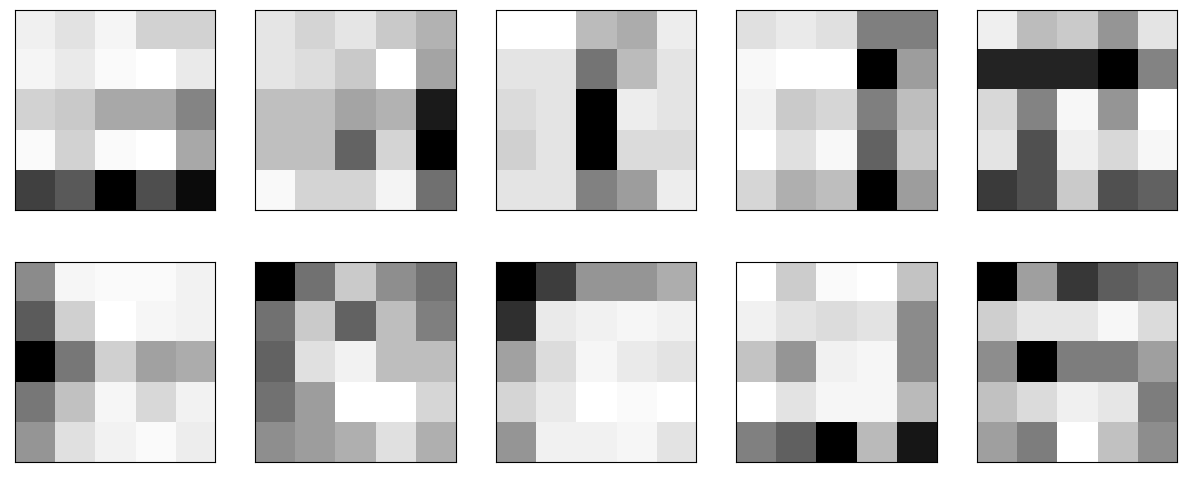

In [30]:
_ = tpc_utils.visualize_random_docs(words, sqrt_N_vocab)

Topic-Visualization as heatmaps of topic-word-prevalence

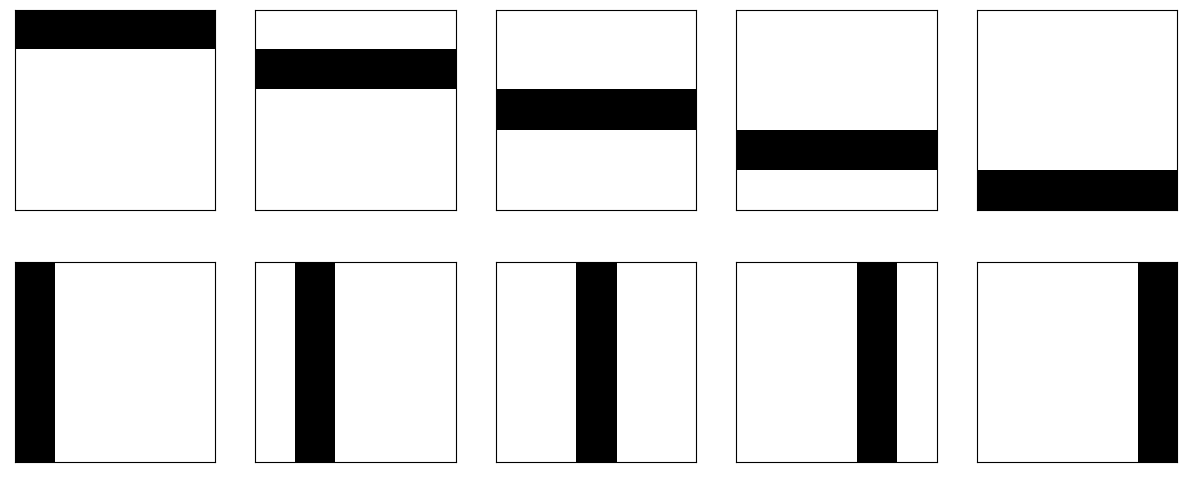

In [31]:
_ = tpc_utils.visualize_topics(topics, 2, sqrt_N_vocab)

---

## Standard Gibbs sampling - Fixed Document Length

In [32]:
## Extracting Observable Data (words only)
*_, words = data_fixed_N.extract_params()

In [33]:
## Usage with "full"-processing
model1 = tpc_sampler.gibbsSampler(K_topics=2*sqrt_N_vocab, fit_procedure="standard")
model1.fit(words, N_iter=200)

100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


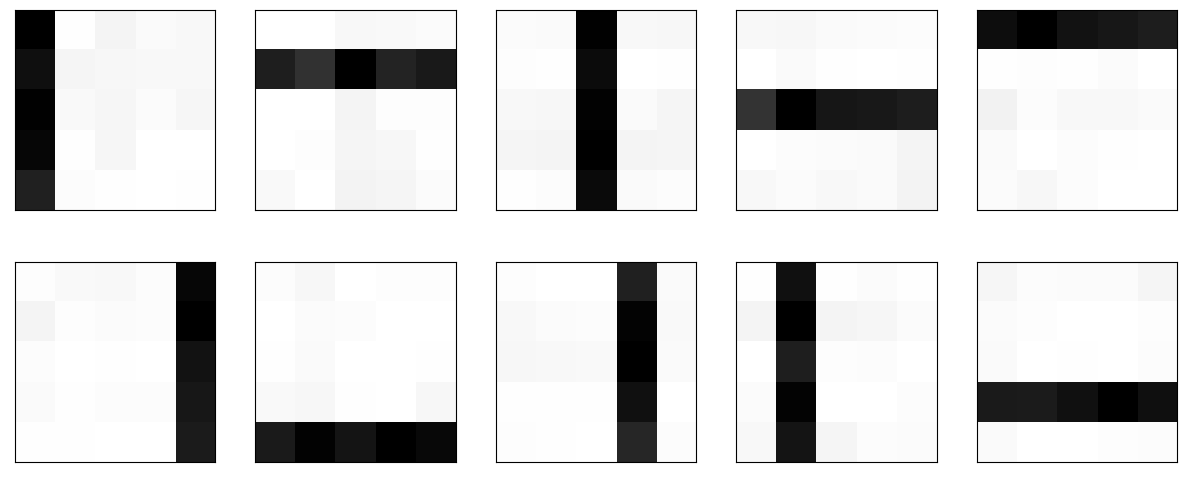

In [34]:
fig = tpc_utils.visualize_topics(model1.Theta, 2, sqrt_N_vocab)

In [35]:
## Usage with batch processing
model2 = tpc_sampler.gibbsSampler(K_topics=2*sqrt_N_vocab, fit_procedure="standard")
model2.fit(words, n_batch=512, n_epochs=100, verbose=1)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


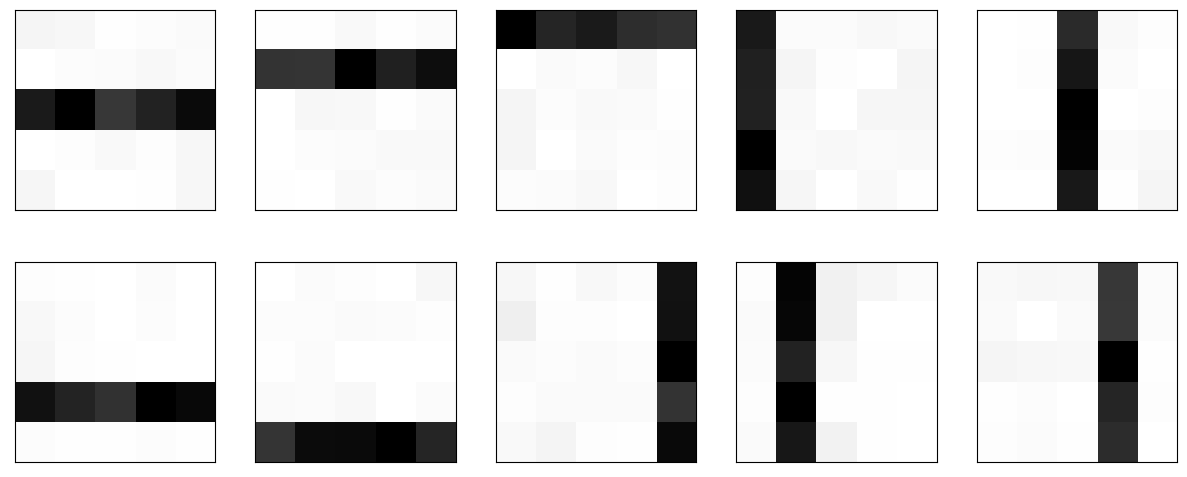

In [36]:
fig = tpc_utils.visualize_topics(model2.Theta, 2, sqrt_N_vocab)

In [41]:
## Shape of Pi includes remainder:
model2.Pi.shape

TensorShape([1000, 10])

---------------------------

## Standard Gibbs sampling - Variable Document Length

In [37]:
## Extracting Observable Data (words only)
*_, words = data_random_N.extract_params()

In [38]:
## Usage with "full"-processing
model3 = tpc_sampler.gibbsSampler(K_topics=2*sqrt_N_vocab, fit_procedure="standard")
model3.fit(words, N_iter=200)

100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


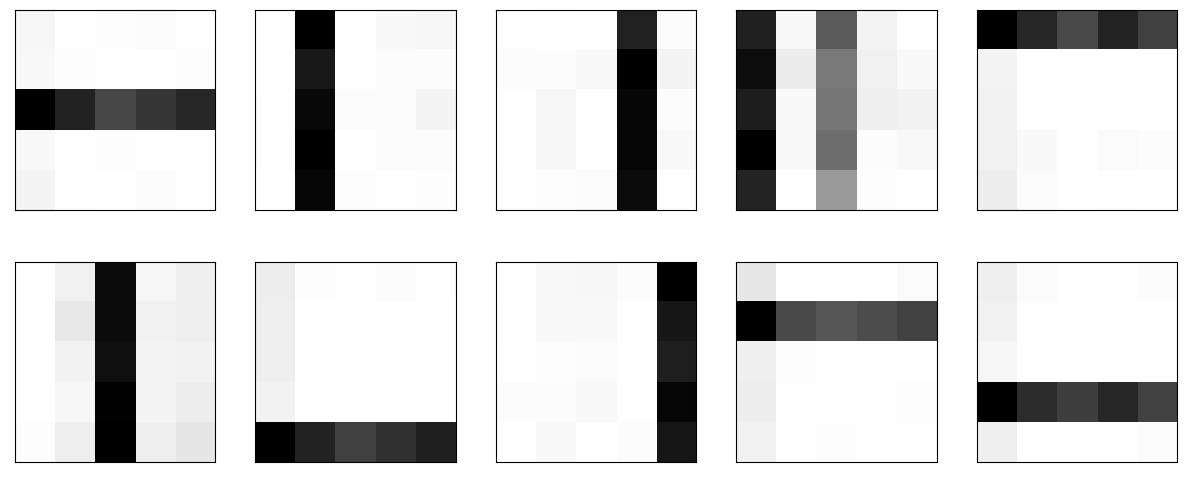

In [39]:
fig = tpc_utils.visualize_topics(model3.Theta, 2, sqrt_N_vocab)

In [42]:
## Usage with batch processing
model4 = tpc_sampler.gibbsSampler(K_topics=2*sqrt_N_vocab, fit_procedure="standard")
model4.fit(words, n_batch=500, n_epochs=100, verbose=1)

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


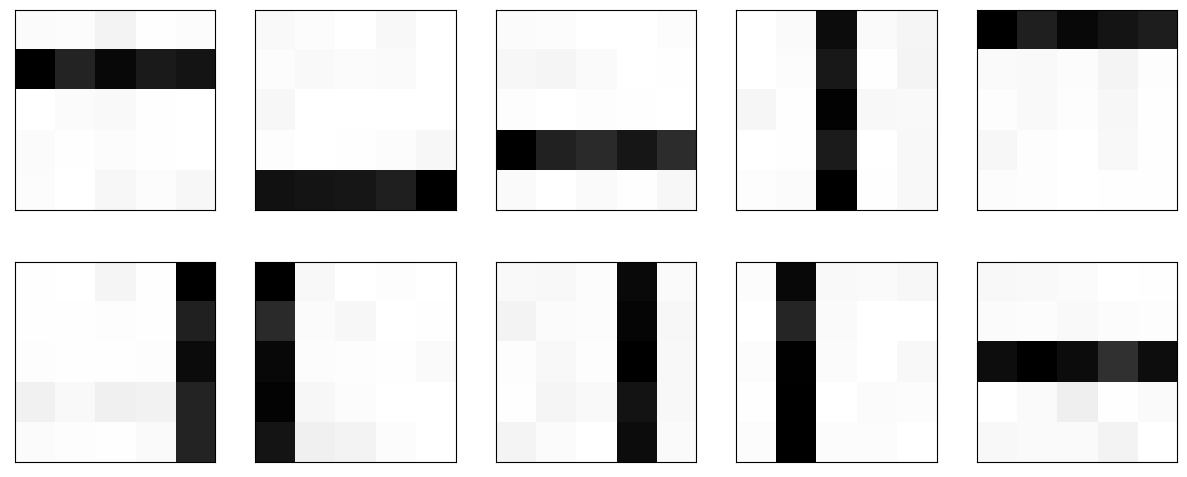

In [43]:
fig = tpc_utils.visualize_topics(model4.Theta, 2, sqrt_N_vocab)

---

## Collapsed Gibbs Sampling

Because I did not go through all the pitfalls to vectorize the collapsed version of the Gibbs sampler. Also because of that, there is not need to switch between a "full" and a batched mode. The algorithm works as the following example shows:

In [44]:
## Extracting Observable Data (words only)
*_, words = data_random_N.extract_params()

In [45]:
## Only "full"-processing implmented
model5 = tpc_sampler.gibbsSampler(K_topics=2*sqrt_N_vocab, fit_procedure="collapsed")
model5.fit(words, N_iter=50)

  6%|▌         | 3/50 [00:51<13:32, 17.29s/it]


KeyboardInterrupt: 

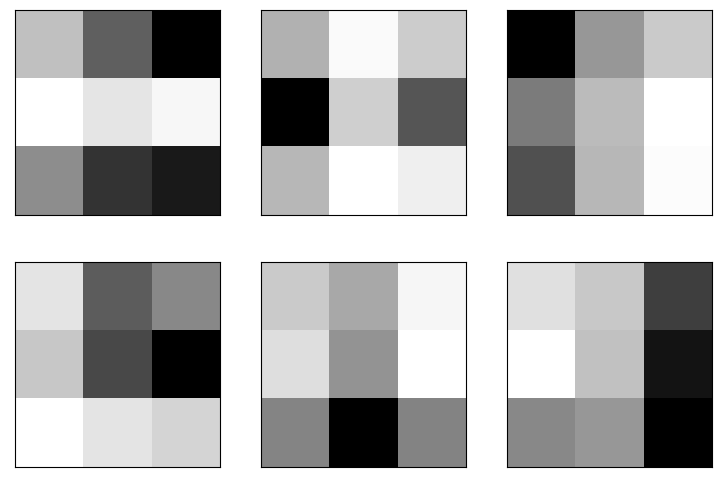

In [ ]:
fig = tpc_utils.visualize_topics(model5.Theta, 2, sqrt_N_vocab)

---

## Presenting `gibbsSampler.predict()` - Method

The sampler keeps track of the $\Pi$ and $\Theta$ values when fitted. To infer $\Pi$ for new data, the $\Theta$ from the fit gets reused.

In [46]:
data_test  = tpc_data.squareLDDocuments(
    N_docs=1000, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words_rate=300,
    Theta_overwrite=model1.Theta,
    alpha=1.)

In [47]:
Theta_test, Pi_test, *_, words_test = data_test.extract_params()

In [59]:
errs    = []
N_iters = []

for it in tqdm(range(0, 20)):
    Pi_pred = model1.predict(words_test, N_iter=it)
    errs.append(np.mean(np.sqrt((Pi_pred - Pi_test)**2)))
    N_iters.append(it)

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


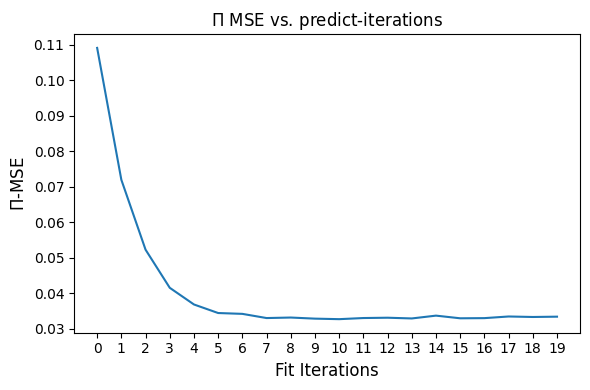

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(N_iters, errs)
ax.set_xlabel('Fit Iterations', fontsize=12)
ax.set_ylabel('$\Pi$-MSE', fontsize=12)
ax.set_xticks(N_iters)
ax.set_title("$\Pi$-MSE vs. predict-iterations")
fig.tight_layout()